In [1]:
from explaneat.data.uci import UCI_WRANGLER
from explaneat.experimenter.experiment import GenericExperiment
from explaneat.evaluators.evaluators import binary_cross_entropy

import torch
import torch.nn as nn
import torch.optim as optim

import logging
import random

import os

import neat

import pprint

from explaneat.core.neuralneat import NeuralNeat as nneat
from explaneat.core import backprop
from explaneat.core.backproppop import BackpropPopulation
from explaneat.visualization import visualize
from explaneat.core.experiment import ExperimentReporter
from explaneat.core.utility import one_hot_encode
from explaneat.core.explaneat import ExplaNEAT

from explaneat.experimenter.results import Result, ResultsDatabase

from copy import deepcopy

from datetime import datetime

import pandas as pd

import gzip
try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error

In [2]:
use_dev_results = True
results_db_location = "./../../data/processed/resultsDatabase.csv" if not use_dev_results else "./../../data/processed/resultsDatabase_DEV.csv"

experiment_config_file = './experiment_config-fast.json'
experiment = GenericExperiment(experiment_config_file, confirm_path_creation=False)
resultsDB = ResultsDatabase(results_db_location)
logger = experiment.logger

2022-07-06 11:22:36,365 - experimenter - INFO - Validating configuration schema
2022-07-06 11:22:36,366 - experimenter - INFO - Schema validation passed
2022-07-06 11:22:36,366 - experimenter - INFO - Starting to create folder structures
2022-07-06 11:22:36,367 - experimenter - INFO - Experiment folder name is test_experiment_220706T112236_700242ae
2022-07-06 11:22:36,367 - experimenter - INFO - Experiment root path is ./../../data/experiments/tests/test_experiment_220706T112236_700242ae
2022-07-06 11:22:36,367 - experimenter - INFO - Creating the root path
2022-07-06 11:22:36,368 - experimenter - INFO - Root path created
2022-07-06 11:22:36,368 - experimenter - INFO - Creating results
2022-07-06 11:22:36,368 - experimenter - INFO - Creating results/interim
2022-07-06 11:22:36,369 - experimenter - INFO - Creating results/final
2022-07-06 11:22:36,369 - experimenter - INFO - Creating configurations
2022-07-06 11:22:36,369 - experimenter - INFO - Creating logs
2022-07-06 11:22:36,370 - e

In [3]:

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
device = torch.device("cuda:1" if USE_CUDA else "cpu")
logger.info("Using device: {}".format(device))


2022-07-06 11:22:36,384 - experimenter - INFO - Using device: cpu


# BC Experiment

This experiment (a) test the experimental environment, but is also to evaluate the efficacy of the ExplaNEAT algorithm. Speed is a critical factor, as well as stability of results on population size. Total run time will also be measured

First, we need to set a random seed and a total stopping point in the number of generations

In [4]:
random.seed(experiment.config["random_seed"])
logger.info("random.seed set to {}".format(experiment.config["random_seed"]))

2022-07-06 11:22:36,395 - experimenter - INFO - random.seed set to 42


## Dataset

We are going to work with the Iris dataset, which will be loaded from `sklearn`. We want to characterise the efficacy of the algorithm with regards to a mostly untransformed dataset, so we will only normalise the features

In [5]:
data_wrangler = UCI_WRANGLER(
        experiment.config['data']['raw_location'],
        experiment.config['data']['raw_data_meta'])




2022-07-06 11:22:36,402 - experimenter.uci_wrangler - INFO - Loading meta file
2022-07-06 11:22:36,403 - experimenter.uci_wrangler - INFO - Loading raw data file
2022-07-06 11:22:36,409 - experimenter.uci_wrangler - INFO - Preprocessing data
2022-07-06 11:22:36,410 - experimenter.uci_wrangler - INFO - ys shape is (286,)
2022-07-06 11:22:36,411 - experimenter.uci_wrangler - INFO - recasting ys to (n,1)
2022-07-06 11:22:36,411 - experimenter.uci_wrangler - INFO - Finished preprocessing data


In [6]:
data_wrangler.create_train_test_split(experiment.config["train_test_ratio"],
            experiment.config["random_seed"])
data_wrangler.send_train_test_to_device(device)

2022-07-06 11:22:36,417 - experimenter.uci_wrangler - INFO - Creating train test split
2022-07-06 11:22:36,418 - experimenter.uci_wrangler - INFO - split created
2022-07-06 11:22:36,418 - experimenter.uci_wrangler - INFO - sending train test to device cpu
2022-07-06 11:22:36,419 - experimenter.uci_wrangler - INFO - train test are on device cpu


## Performance metric

The NEAT implementation on which ExplaNEAT extends uses a single function call for evaluating fitness. Although this might be reworked for ExplaNEAT to be able to get consistency between the genome-evaluation and the backprop loss function, that can be reviewed later.

This use `CrossEntropyLoss` from `PyTorch`

## Base configuration

We are going to create the base configuration according to an external configuration file. Per experiment, we will adjust this, later, but this defines the defaults across all runs.

In [7]:
config_path = "./config-bchard"
base_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)


In [8]:
experiment.register_config_file("./config-bchard", "neat_config")

2022-07-06 11:22:36,435 - experimenter - INFO - Saving experiment configuration
2022-07-06 11:22:36,436 - experimenter - INFO - Saving other config files


We also want to put a hard limit on how long this can go on for.

We will create a method to manage the instantiation of a population on the basis of a specific config.

In [9]:
def instantiate_population(config, xs, ys, saveLocation):

    if not os.path.exists(saveLocation):
        os.makedirs(saveLocation)
        
    config.save(os.path.join(saveLocation, 'config.conf'))

    # Create the population, which is the top-level object for a NEAT run.
    p = BackpropPopulation(config, 
                            xs, 
                            ys, 
                            criterion=nn.BCELoss())

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5, filename_prefix=str(saveLocation) + "checkpoint-" ))
    bpReporter = backprop.BackpropReporter(True)
    p.add_reporter(bpReporter)
    p.add_reporter(ExperimentReporter(saveLocation))
    
    return p

# Experiment 1: Vary population size

The first experiment is going to examine the difference in run time different population sizes. 

In [10]:
# epoch_points = [10, 25, 50, 100, 150]
epoch_points = [10]

In [11]:
base_config.pop_size

50

In [12]:
saveLocationTemplate = './../../data/experiments/bchard/experiment-test-{}-{}/'

## Start the experiment

In [13]:
len(data_wrangler.X_train.shape)

2

In [14]:
data_wrangler.ys.dtype

dtype('float64')

In [15]:
my_random_seed = experiment.config["random_seed"]
for epochs in epoch_points:
    for iteration_no in range(1):
        my_random_seed += 1
        random.seed(my_random_seed)
        start_time = datetime.now()
        
        logger.info("################################################")
        logger.info("################################################")
        logger.info("Starting epochs {} iteration {}".format(epochs, iteration_no))
        logger.info("Started at {}".format(start_time.strftime("%m/%d/%Y, %H:%M:%S")))
        logger.info("################################################")
        logger.info("################################################")
        
        
        config = deepcopy(base_config)
#         config.pop_size = pop_size
        
        saveLocation = saveLocationTemplate.format(epochs, iteration_no)
        
        p = instantiate_population(config, data_wrangler.X_train, data_wrangler.y_train, saveLocation)
        # Run for up to nGenerations generations.
        winner = p.run(binary_cross_entropy, experiment.config["max_n_generations"], nEpochs = epochs)
        
        g = p.best_genome

        explainer = ExplaNEAT(g, config)

        g_result = Result(
            g,
            "best_genome",
            experiment.config['experiment']['name'],
            experiment.config['data']['raw_location'],
            experiment.experiment_sha,
            iteration_no,
            {
                "iteration":iteration_no,
                "n_epochs":epochs
            }
        )
        resultsDB.add_result(g_result)

        g_map = Result(
            visualize.draw_net(config, g).source,
            "best_genome_map",
            experiment.config['experiment']['name'],
            experiment.config['data']['raw_location'],
            experiment.experiment_sha,
            iteration_no,
            {
                "iteration":iteration_no,
                "n_epochs":epochs
            }
        )
        resultsDB.add_result(g_map)


        skippiness = Result(
            explainer.skippines(),
            "skippiness",
            experiment.config['experiment']['name'],
            experiment.config['data']['raw_location'],
            experiment.experiment_sha,
            iteration_no,
            {
                "iteration":iteration_no,
                "n_epochs":epochs
            }
        )
        resultsDB.add_result(skippiness)
        
        end_time = datetime.now()
        
        p.reporters.reporters[2].save_checkpoint(p.config, p.population, p.species, str(p.generation) + "-final")  
        
        winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

        results = []
        for xi, xo in zip(data_wrangler.X_test, data_wrangler.y_test):
            output = winner_net.activate(xi)
            results.append([xi, xo, output])

        df = pd.DataFrame(results)
        df.to_csv(os.path.join(saveLocation, 'results.csv'))

        # g_result = Result(
        #     df,
        #     "results",
        #     experiment.config['experiment']['name'],
        #     experiment.config['data']['raw_location'],
        #     experiment.experiment_sha,
        #     iteration_no,
        #     {
        #         "iteration":iteration_no,
        #         "n_epochs":epochs
        #     }
        # )
        # resultsDB.add_result(g_result)

        ancestry = p.reporters.reporters[3].trace_ancestry_of_species(g.key, p.reproduction.ancestors) 

        ancestors = {
            k: v['genome'] for k, v in p.reporters.reporters[3].ancestry.items()
        }

        ## Save all of these to disc
        filename = 'fullStatus.xplnt'
        logger.info("Saving checkpoint to {0}".format(filename))

        resultsDB.save()

#         with gzip.open(os.path.join(saveLocation, filename), 'w', compresslevel=5) as f:
#             data = (p, g, ancestry, ancestors, random.getstate())
#             pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
            
            
#         with gzip.open(os.path.join(saveLocation, 'train_test_data.pkl'), 'w', compresslevel=5) as f:
#             train_Test = (data_wrangler.X_train, data_wrangler.X_test, data_wrangler.y_train, data_wrangler.y_test)
#             pickle.dump(train_Test, f, protocol=pickle.HIGHEST_PROTOCOL)
    

2022-07-06 11:22:36,488 - experimenter - INFO - ################################################
2022-07-06 11:22:36,489 - experimenter - INFO - ################################################
2022-07-06 11:22:36,490 - experimenter - INFO - Starting epochs 10 iteration 0
2022-07-06 11:22:36,490 - experimenter - INFO - Started at 07/06/2022, 11:22:36
2022-07-06 11:22:36,490 - experimenter - INFO - ################################################
2022-07-06 11:22:36,491 - experimenter - INFO - ################################################
2022-07-06 11:22:36,496 - experimenter.methodTimer - INFO - The function - generationStart - has just started at 1657063356.496112
2022-07-06 11:22:36,496 - experimenter.methodTimer - INFO - The function - generationStart - took 0.0005509853363037109 seconds to complete
2022-07-06 11:22:36,497 - experimenter.methodTimer - INFO - The function - pre_backprop - has just started at 1657063356.497094
2022-07-06 11:22:36,497 - experimenter.methodTimer - I


 ****** Running generation 0 ****** 

Population's average fitness: 0.76231 stdev: 0.19642
Best fitness: 1.37543 - size: (1, 9) - species 3 - id 29
Key: 29
Fitness: 1.3754269789988238
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.7166086393996857, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-9, 0), weight=0.8023875920018375, enabled=True)
	DefaultConnectionGene(key=(-8, 0), weight=-0.05565851853022853, enabled=True)
	DefaultConnectionGene(key=(-7, 0), weight=-0.38272638594618835, enabled=True)
	DefaultConnectionGene(key=(-6, 0), weight=0.07611590059974982, enabled=True)
	DefaultConnectionGene(key=(-5, 0), weight=0.12679823145115676, enabled=True)
	DefaultConnectionGene(key=(-4, 0), weight=0.4286248093311324, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=-0.17953309783959792, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=-0.14844793071045362, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=0.012388292444680357, enab

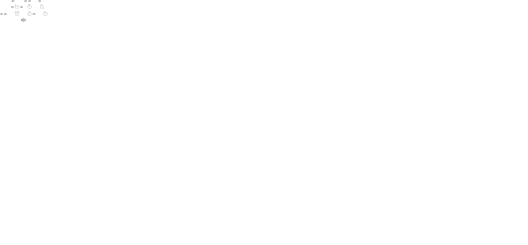

In [16]:
visualize.draw_net(config, g)

In [19]:
resultsDB.data.iloc[1].value

'digraph {\n\tgraph [dpi=800 size="7.75,10.25"]\n\tnode [fontsize=9 height=0.2 shape=circle width=0.2]\n\t-1 [fillcolor=lightgray shape=box style=filled]\n\t-2 [fillcolor=lightgray shape=box style=filled]\n\t-3 [fillcolor=lightgray shape=box style=filled]\n\t-4 [fillcolor=lightgray shape=box style=filled]\n\t-5 [fillcolor=lightgray shape=box style=filled]\n\t-6 [fillcolor=lightgray shape=box style=filled]\n\t-7 [fillcolor=lightgray shape=box style=filled]\n\t-8 [fillcolor=lightgray shape=box style=filled]\n\t-9 [fillcolor=lightgray shape=box style=filled]\n\t0 [fillcolor=lightblue style=filled]\n\t167 [fillcolor=white style=filled]\n\t104 [fillcolor=white style=filled]\n\t233 [fillcolor=white style=filled]\n\t433 [fillcolor=white style=filled]\n\t275 [fillcolor=white style=filled]\n\t212 [fillcolor=white style=filled]\n\t-1 -> 0 [color=red penwidth=0.13071702900822949 style=solid]\n\t-3 -> 0 [color=red penwidth=0.22708203498825372 style=dotted]\n\t-4 -> 0 [color=green penwidth=0.225281

In [20]:
import graphviz

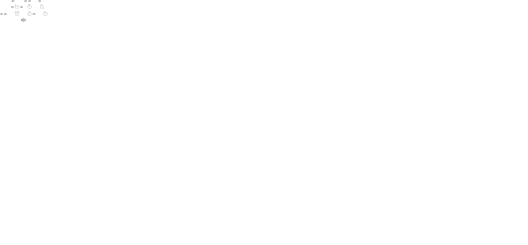

In [21]:
# graphviz.Source(resultsDB.data.iloc[1].value)

In [22]:
results

[[tensor([-0.6577,  0.9145, -0.4191, -0.4566,  0.3795, -0.0664,  1.0650, -0.9702,
           0.5585], dtype=torch.float64),
  tensor([0.], dtype=torch.float64),
  [0.0]],
 [tensor([ 1.3224, -0.9145, -0.4191,  6.5083, -1.8816,  1.2906, -0.9389, -0.1468,
          -1.7905], dtype=torch.float64),
  tensor([1.], dtype=torch.float64),
  [tensor(3.6680, dtype=torch.float64)]],
 [tensor([-0.6577,  0.9145,  1.9593, -0.4566,  0.3795, -0.0664, -0.9389, -0.1468,
          -1.7905], dtype=torch.float64),
  tensor([0.], dtype=torch.float64),
  [0.0]],
 [tensor([-0.6577,  0.9145,  0.5322, -0.4566,  0.3795,  1.2906,  1.0650,  0.6765,
           0.5585], dtype=torch.float64),
  tensor([1.], dtype=torch.float64),
  [0.0]],
 [tensor([ 0.3323,  0.9145,  0.5322, -0.4566,  0.3795,  1.2906,  1.0650, -0.9702,
          -1.7905], dtype=torch.float64),
  tensor([1.], dtype=torch.float64),
  [0.0]],
 [tensor([ 1.3224, -0.9145,  1.4836,  0.4140,  0.3795, -0.0664,  1.0650, -0.9702,
          -1.7905], dtype=torch

In [23]:
binary_cross_entropy

<function explaneat.evaluators.evaluators.binary_cross_entropy(genomes, config, xs, ys, device)>

In [24]:
import torch.nn as nn


In [25]:
loss = nn.BCELoss()

In [47]:
y_test = [r[1] for r in results]
preds = [r[2][0] for r in results]
preds = [1 if r > 0 else 0 for r in preds]

In [48]:
y_test

[tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([1.], dtype=torch.float64),
 tensor([1.], dtype=torch.fl

In [49]:
torch.tensor(y_test)

tensor([0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [50]:
loss(torch.tensor(preds), torch.tensor(y_test))

RuntimeError: Found dtype Double but expected Long

In [46]:
torch.tensor(preds)

tensor([0.0000, 3.6680, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.3698, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.2182, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)